# CT / Histology Correlation Phantom #

## Authors: Philipp Nolte & Dr. Christian Dullin ##
 
This Code was created to correlate histology sections of hard tissue with an a priori CT-scan of the same sample using 3D printed phantoms.<br> 
The corresponding publication can be found here: 



In [1]:
### Import Dependencies ###

# Standard Libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings
import os

# Load and Visualize Data
from mayavi import mlab

# Image Processing
from scipy.ndimage import label, binary_erosion, binary_dilation, binary_fill_holes, rotate
from skimage import img_as_ubyte
from skimage.measure import regionprops
from skimage.io import imread, imsave
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte
from skimage.morphology import disk
import cv2
from PIL import Image
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

# 1D Image Processing 
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

# Registration
import SimpleITK as sitk
import matplotlib.pyplot as plt
from IPython.display import clear_output
from skimage.util import compare_images

In [2]:
### Load and save CT-scan .vox format to np.ndarray ### 
def loadVOX(fname):
    vol=[]
    try:
        f=open(fname,"rb")
        size=os.path.getsize(fname)
        f.seek(size-512*512*512*2)
        vol=np.reshape(np.frombuffer(f.read(512*512*512*2),dtype='ushort'),(512,512,512),order='F').swapaxes(0,1)
    finally:
        f.close()
    return vol

In [3]:
### Helper function to call the 3d render window from the mayavi api ### 
def mayaviz(volume):
    field = mlab.pipeline.scalar_field(volume)
    cont = mlab.pipeline.contour(field)
    surf= mlab.pipeline.surface(cont, opacity=0.5)
    mlab.pipeline.add_module_manager(cont)
    mlab.show()

In [4]:

def findphantom(labels,num_features,num_obj):
    """
    Identifies the three cones in the ct volume based on the assumtion that they are the 2nd to fourth biggest objects
    
    Keyword arguments:
    labels       -- 3d numpy array containing all objects with associated labels in a range from 0 to n
    num_features -- The total number n of labeled objects
    num_ob       -- number of phantoms which will be segemented. In our case the value is 3.
    
    """
    largest_obj =  []
    max_obj = []
    final_obj =  []
    # Get the number of voxel associated to the indivual label
    for i  in range(1,num_features+1):
       #print(str(i)+" "+str(np.count_nonzero(labels==i)))
        largest_obj.append(np.count_nonzero(labels==i))

    # Sort list from largest to smallest
    for i in range(1,num_obj+1):
        obj = sorted(largest_obj, reverse = True)[:i+1]
        max_obj.append(obj)

    #get the n largest objects. Remove the largest one since its mostlikely the bone
    ind_obj = max_obj[num_obj-1]
    ind_obj.remove(max(ind_obj))
    #print(ind_obj)
    
    #get label index
    for i in range(len(ind_obj)):
        final_obj.append(largest_obj.index(ind_obj[i])+1)
    #print(final_obj)
    return final_obj

In [5]:
def get_axis_inertia(vk):
    """
    Computes the axis of inertia for a givin phantom
    
    Keyword arguments:
    vk -- 3d numpy array containing one phantom
    
    """
    #binarize volume 
    ones = np.where(vk > 0)
    #Create an array from the obtained tuple and transpose it
    ones_array = np.array([ones[0], ones[1], ones[2]]).T
    print(ones_array.shape)
    #take the mean of the 2D array
    centroid= np.mean(ones_array,axis=0) 
    #Center the points around the mean and compute the covariance matrix
    S = np.cov((ones_array-centroid).T)
    print(centroid)
    #compute the eigenvalues and eigenvectors and sort them according to the eigenvalues 
    w,v = np.linalg.eig(S)
    order = np.flip(np.argsort(w))
    v[:,[0,1,2] ] = v[:, [order[0],order[1],order[2]]]
    print(w,v)
    return centroid,v

In [6]:
def slice_center(aikv, centroid,vk):
    """
    Creates an image of the center section for a phantom. Center section is the plane that inclosed by two eigenvectors.

    Keyword arguments:
    aikv     -- Eigenvectors of the cone
    centroid -- center of gravity of the cone
    vk       -- 3d numpy array containing one phantom
    
    """
    cut_image = np.zeros([512,512])
    c,l = cut_image.shape
    #Iterate through all pixels of the resulting image 
    for i in range(0,c):
        for j in range(0,l):
            #center around ther the middle of the image 
            offset = np.array([i-256,0,j-256])
            #compute corresponging voxel for each pixel
            valcoord = np.matmul(aikv,offset.T)+centroid.T
            #check if voxel is still in the volume
            if valcoord[0] < 512 and valcoord[1] < 512 and valcoord[2] < 512: 
                # obtain voxel value from 3d array
                val = vk[int(valcoord[0]),int(valcoord[1]),int(valcoord[2])]
                #set pixel value in 2d image
                cut_image[i,j] = val
    #plt.imshow(cut_image)
    return cut_image

In [7]:
def get_diameter(aikv, centroid,vk):
    
    """
    Create a 2d section of the 3d volume and count the diameter of the cone for each row.

    Keyword arguments:
    aikv     -- Eigenvectors of the cone
    centroid -- center of gravity of the cone
    vk       -- 3d numpy array containing one phantom
    
    """
   
    cut_image = slice_center(aikv, centroid, vk)
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ones = np.where(cut_image > 0)

    y_max = np.max(ones[0])


    #Check if the cone is facing upwards and turn by 180 degress if necessary it if necessary 
    if 300-y_max < 0:
        rotated = rotate(cut_image, angle=-180, reshape= False)
        rotated[rotated<.8] = 0
        rotated[rotated>.8] = 1
        im_input = rotated
    else:
        im_input = cut_image 

    #Visualize the cone and center of gravity     
    im_input = binary_fill_holes(im_input, structure=np.ones((5,5))).astype(int);     
    plt.imshow(im_input) 
    im_input1 = np.copy(im_input)        
    im_input1 = cv2.circle(im_input1, center=(int(256),int(256)), radius=4,color =0,  thickness=10)
    plt.imshow(im_input1,cmap = "gray")
    plt.savefig('cone.png', dpi=600)


    # Count cone pixels above and below of the center of gravity and save them in an array
    num_ones = []
    pointsabove =[]
    pointsbelow =[]
    i = 1

    while(1):
        if(im_input[int(256+i)][int(256)] > 0):
            pointsabove.append(int(256)+i)
            i=i+1
        else:
            break
    i = 0
    while(1):
        if(im_input[int(256)-i][int(256)] > 0):
            pointsbelow.append(int(256-i))
            i=i+1
        else:
            break
    pointsbelow.reverse()

    points = pointsbelow+pointsabove
    

    diameter = []
    num_ones = []
    points1 = []

    #Delete Zeros from list
    pos_centroid = len(pointsbelow)
    for r in points:
        num_ones.append(np.count_nonzero(im_input[r,:] ) )
        diameter = np.trim_zeros(num_ones)
    
    
   #Negate list
    for i in range(len(points)):
        points1.append(points[i]-points[pos_centroid])
    points1t = [ -x for x in points1]
   
   #Smoothen and plot height vs. diameter relationship
    xx = np.linspace(np.min(points1t),np.max(points1t), len(points1t))
    itp = interp1d(points1t,diameter, kind='nearest')
    window_size, poly_order = 5, 3
    yy_sg = savgol_filter(itp(xx), window_size, poly_order)
    fig, ax = plt.subplots(1,2,figsize=(20, 10))
    ax[1].set_title("Diameter vs. Height",fontsize=20)
    ax[1].set_xlabel("Height [mm]",fontsize=15)
    ax[1].set_ylabel("Diameter [mm]",fontsize=15)
    ax[1].plot(xx*ct_scale, yy_sg*ct_scale, 'k', label= "Smoothed curve")
    im_input = im_input[150:350,150:350]
    ax[0].set_title("Crosssection of a segmented phantom",fontsize=20)
    ax[0].imshow(np.invert(im_input),cmap = "gray", extent=[0,16,16,0])
  
    #Insert Scale bar in plot and save figgure 
    scalebar = AnchoredSizeBar(ax[0].transData,
                           5, '5 mm', 'lower right', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=0,
                           fontproperties=fm.FontProperties(size=18))
    ax[0].add_artist(scalebar)
   
    plt.savefig('graph.png',dpi=600)

    return fig,yy_sg,xx




In [8]:
### Const Parameters ###

# Files
ct_file  = 'data/K270323_6/K270323_6.VOX'
img_file = "data/K270323_6/K270323_6_2.tif"

# Scales
hist_scale = 0.0059
ct_scale   = 0.08



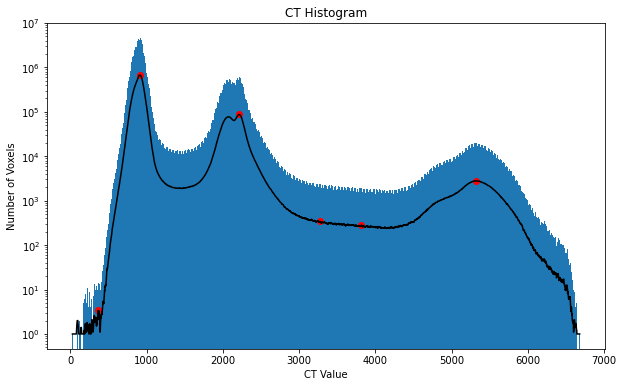

Thresholding
Dimensions: (512, 512, 512)
Mean value: 1193.2414982020855
Min value: 0
Max value: 6678
Thresholding value: 2942.467562080275


In [9]:
### Load CT-Data and Tresholding ###

volume = loadVOX(ct_file )
v1 = np.copy(volume)
v2 = np.copy(volume)

xx_peaks = []
#Plot Histogram
flat_data = v1.reshape(-1)
#Remove all the zeros since there is no information 
flat_data = flat_data[flat_data != 0]
fig = plt.figure(figsize=(10, 6))
plt.hist(flat_data, bins = 1000);
unique, counts = np.unique(flat_data, return_counts=True)
itp = interp1d(unique,counts, kind='nearest')
window_size, poly_order =10, 1
xx = np.linspace(np.min(unique),np.max(unique), len((unique)))
yy_sg = savgol_filter(itp(xx), window_size, poly_order)
plt.plot(xx, yy_sg, 'k', label= "Smoothed curve")
peaks= find_peaks(yy_sg, distance = 500, width = 10)
for i in peaks[0]:
    plt.scatter(xx [i], yy_sg[i],color =[1,0,0])
    xx_peaks.append(xx[i])
   
#select appropriate threshold
thresh =xx_peaks[-3]*0.9
#limit the  y-axis so we can have a better look at the distribution
plt.yscale('log')
#plt.ylim(0,2*10e4) 
plt.title('CT Histogram')
plt.xlabel('CT Value')
plt.ylabel('Number of Voxels')
plt.show()

print("Thresholding")
print("Dimensions: " + str(v1.shape))

print("Mean value: " + str(v1.mean()))
print("Min value: " + str(v1.min()))
print("Max value: " + str(v1.max()))
print("Thresholding value: " + str(thresh))

#Automated thresholding. Experimental Value based on best seperation of bone and cone
#thresh = 450
v1[v1 < thresh] = 0

# Check Orientation of the scan 
# z should be facing up

v1 = np.swapaxes(v1, 0, 2)
v1 = v1[:,:,::-1]

#mayaviz(v1)

hi1
hi1
1614
CT-Value Range of vk1: 1614 to 5364
CT-Value Range of vk2: 1401 to 2376
CT-Value Range of vk3: 1516 to 2307
CT-Value Range of the Bone: 2943 to 6678


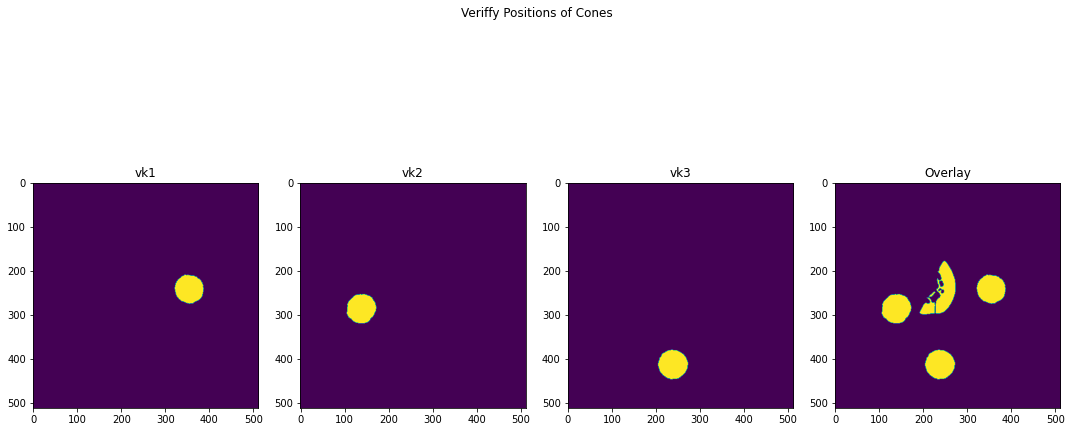

In [10]:
### segment cones and bone and label them ###

labelsv1, numfeaturesv1 = label(v1)
print("hi1")
#Use proprietary function to find the three cones
final_obj = findphantom(labelsv1, numfeaturesv1, 3);
print("hi1")
#Create volums with only the cones in 
vk1 = np.copy(v1)
vk2 = np.copy(v1)
vk3 = np.copy(v1)
# These are used to calculate the ct value range
vk1d = np.copy(v2)
vk2d = np.copy(v2)
vk3d = np.copy(v2)

#segment the cones
vk1[labelsv1 !=final_obj[0]] =0
vk2[labelsv1 !=final_obj[1]] =0
vk3[labelsv1 !=final_obj[2]] =0


vk1d[labelsv1 !=final_obj[0]] =0
vk2d[labelsv1 !=final_obj[1]] =0
vk3d[labelsv1 !=final_obj[2]] =0

#everything that is not a cone, must be the bone
vkbone = v1-vk1-vk2-vk3

#remove all values == 0
vk1_list = vk1d[vk1d>0]
vk2_list = vk2d[vk2d>0]
vk3_list = vk3d[vk3d>0]
vkbone_list = vkbone[vkbone>0]

#print the ct value ranges for each cone and the bone
print(np.min(vk1_list))
print("CT-Value Range of vk1: "+str(np.min(vk1_list))+" to "+str(np.max(vk1_list)) )
print("CT-Value Range of vk2: "+str(np.min(vk2_list))+" to "+str(np.max(vk2_list)) )
print("CT-Value Range of vk3: "+str(np.min(vk3_list))+" to "+str(np.max(vk3_list)) )
print("CT-Value Range of the Bone: "+str(np.min(vkbone_list))+" to "+str(np.max(vkbone_list)) )



#Binarises the volumes
vk1[vk1 > 0] = 1
vk2[vk2 > 0] = 1
vk3[vk3 > 0] = 1
vkbone[vkbone > 0] = 1

# Find a Z-Slice with phantoms in it.
ones = np.where(vk1 > 0)
idx1 = ones[2][5]
ones = np.where(vk2 > 0)
idx2 = ones[2][5]
ones = np.where(vk3 > 0)
idx3 = ones[2][5]

#Visualizes a section of the 3 cones to verify that these are actually segmented
overlay = vk1[:,:,idx1]+vk2[:,:,idx2]+vk3[:,:,idx3]+vkbone[:,:,350]
fig,ax = plt.subplots(1,4, figsize=(15,8))
fig.suptitle("Veriffy Positions of Cones")
fig.set_tight_layout(True)
angle = -180
ax[0].set_title("vk1")
ax[0].imshow(rotate(vk1[:,:,idx1], angle=angle, reshape= False))
ax[1].set_title("vk2")
ax[1].imshow(rotate(vk2[:,:,idx2], angle=angle, reshape= False))
ax[2].set_title("vk3")
ax[2].imshow(rotate(vk3[:,:,idx3], angle=angle, reshape= False))
ax[3].set_title("Overlay")
ax[3].imshow(rotate(overlay, angle=angle, reshape= False))

Dimensions of Image
(3381, 4042, 3)


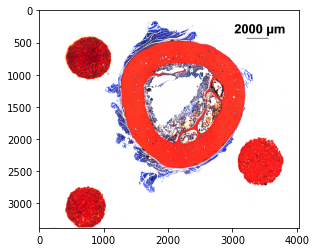

In [11]:
### Load Image Data ###

# Read in image 
im_input = imread(img_file)
# Convert to 8-bit depth so skimage can work on it 
plt.imshow((im_input).astype(np.uint8));
print("Dimensions of Image")
print( im_input.shape)

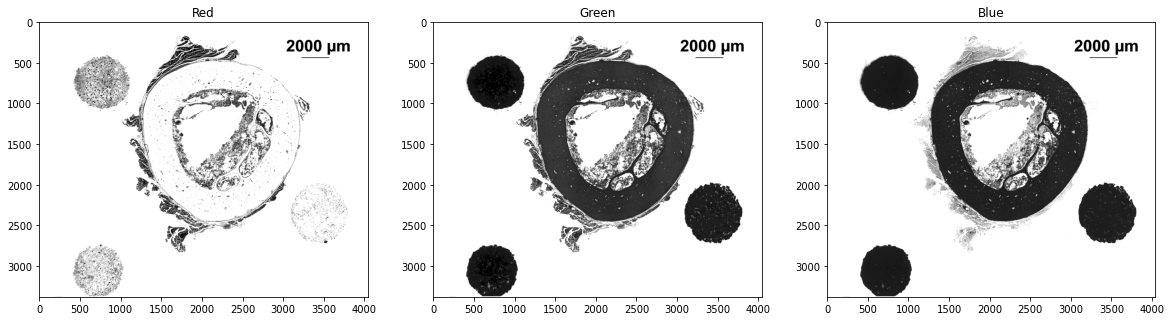

In [12]:
### Plot Image RGB-Channels ###

fig, ax = plt.subplots(1, 3, figsize=(20,20))
ax[0].imshow(im_input[:,:,0], cmap='gray')
ax[0].set_title('Red')
ax[1].imshow(im_input[:,:,1], cmap='gray')
ax[1].set_title('Green')
ax[2].imshow(im_input[:,:,2], cmap='gray')
ax[2].set_title('Blue');

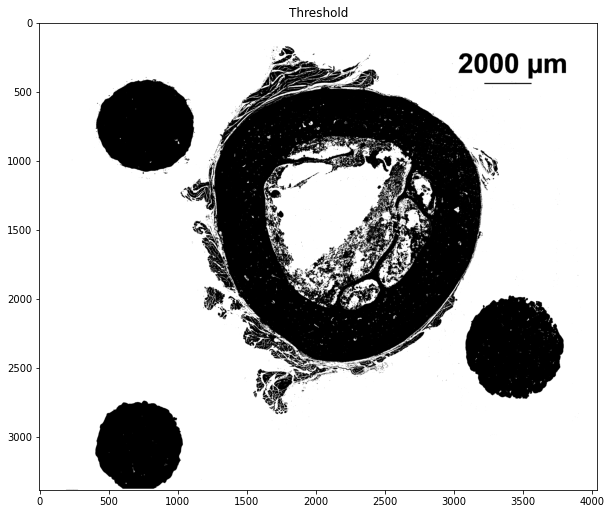

In [13]:
### Threshold Image ####
threshold_global_otsu = threshold_otsu(im_input[:,:,0])
global_otsu = im_input[:,:,1]>= threshold_global_otsu
plt.figure(figsize = (10,10))
plt.imshow(global_otsu, cmap='gray')
plt.title('Threshold');

Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


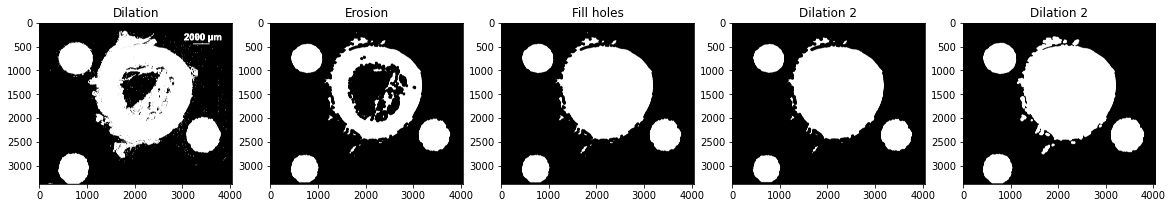

In [14]:
### Morphological filtering to create a mask ###

#invert image so cones and bones are one
im_inv = np.invert(global_otsu);

# Close holes in 3d printed cones (might break open during workflow ?)
r1 = binary_dilation(im_inv,structure=disk(5)) .astype(int);

# Remove everything execpt the cones and bone
r2 = binary_erosion(r1,structure=disk(30)).astype(int);

# Close small holes in the objects
r3 = binary_fill_holes(r2, structure=np.ones((20,20))).astype(int);
r4 = binary_erosion(r3,structure=disk(5)).astype(int);

r5 = binary_dilation(r4,structure=disk(25) ).astype(int);




fig, ax = plt.subplots(1, 5, figsize=(20,20))
ax[0].imshow(r1,cmap='gray') 
ax[0].set_title('Dilation')
ax[1].imshow(r2, cmap='gray')
ax[1].set_title('Erosion')
ax[2].imshow(r3, cmap='gray')
ax[2].set_title('Fill holes')
ax[3].imshow(r4, cmap='gray')
ax[3].set_title('Dilation 2')
ax[4].imshow(r5, cmap='gray')
ax[4].set_title('Dilation 2')




#save so it can be open with OpenCV
warnings.filterwarnings("ignore")
imsave('masku.png', img_as_ubyte(r5));
imsave('mask.png', r5);

     centerx    centery  minoraxis  majoraxis       angle
0  20.293875  13.878057   4.039025   4.239589  164.897507
1   4.567263   4.388414   3.818551   4.086285   96.433556
2   4.283776  18.048711   3.625717   3.728696   12.508581


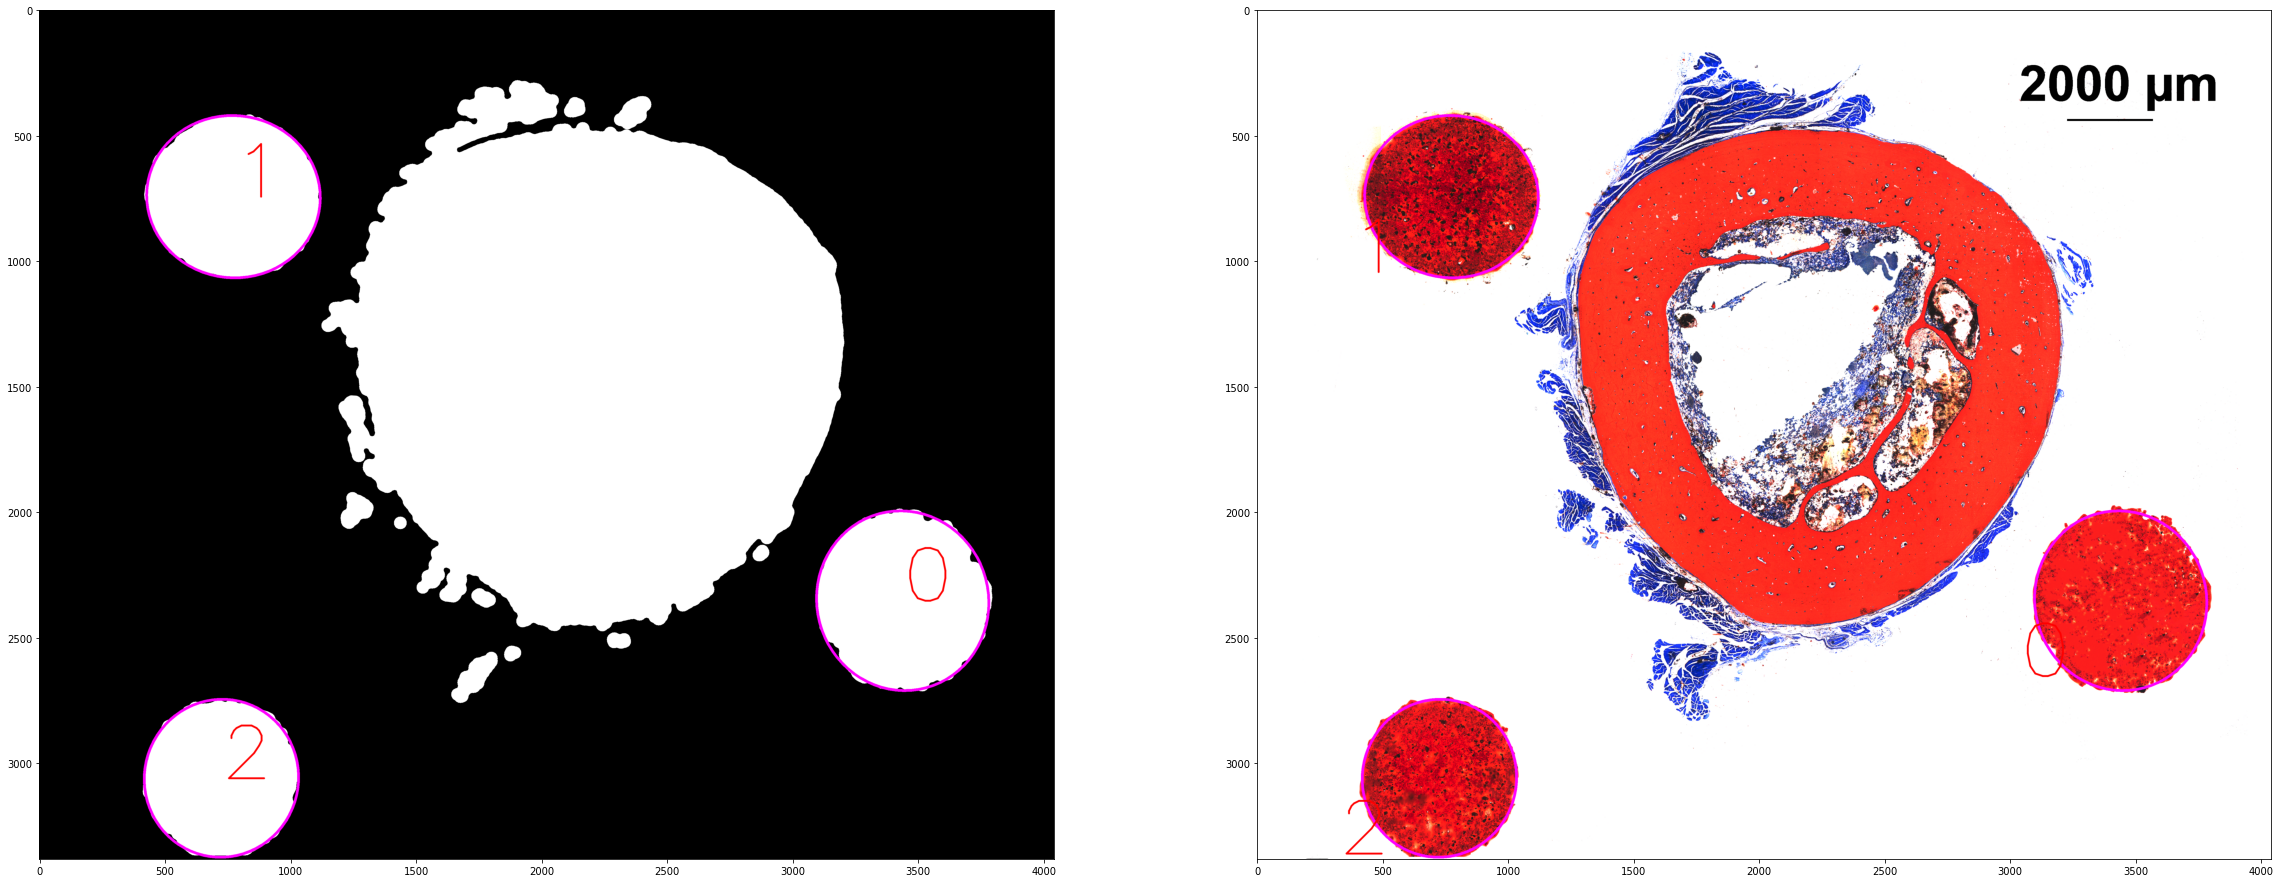

In [15]:
### Find contours in the filtered image and choose the circles ###

#Load Images for OpenCV
I_mask = np.array(Image.open("masku.png"))
I_disp =cv2.imread('mask.png')
Img = np.array(Image.open(img_file))

#An index so the cones get labels 0 to 2
idx_cones = 0

# Get the countours and sort them 
contours , hierarchy = cv2 . findContours ( I_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE )
cnt= sorted(contours, key=cv2.contourArea, reverse= True)

# Prepare array to describe the cones with ellipse parameters
params = []

# iterate over cones, fit ellipses for finding in order to describe the parametes
for i in range(0,len(cnt)):
        #print(cv2.contourArea(cnt[i]))
        # Fit ellipsis in the contours and return parameters 
        # Direct Least Squares https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#gaf259efaad93098103d6c27b9e4900ffa
        # Might need to be adjusted according to the cone size
        if(117145< cv2.contourArea(cnt[i])< 850000):
                ((centx,centy), (width,height), angle) =  cv2. fitEllipseDirect(cnt[i])
                #Check if the ellipses are appropriatly sizes
                if  width >50 and height >50  and width/height > 0.8:
                        # Write the ellipse paremeters in an array
                        params.append([centx,centy,width,height,angle])
                
                        #Superimpose idx_cones and ellipses on image
                        I_disp= cv2.ellipse(I_disp, (int(centx),int(centy)),(int(width/2),int(height/2)), angle, 0, 360, (255,0,255), 10)
                        I_disp= cv2.putText(I_disp,str(idx_cones),(int(centx),int(centy)), cv2.FONT_HERSHEY_SIMPLEX, 10,(255, 0, 0),6, cv2.LINE_AA )
                        Img = cv2.ellipse(Img, (int(centx),int(centy)),(int(width/2),int(height/2)), angle, 0, 360, (255,0,255), 10)
                        Img = cv2.putText(Img,str(idx_cones),(int(centx)-400,int(centy)+300), cv2.FONT_HERSHEY_SIMPLEX, 10,(255, 0, 0),6, cv2.LINE_AA )
                        idx_cones += 1
                
       
#save parameters into a pandas dataframe
df_params = pd.DataFrame(params, columns=['centerx','centery','minoraxis','majoraxis','angle'])
  
# Convert given parameters to [mm]
df_params.loc[:,'majoraxis'] *= hist_scale
df_params.loc[:,'minoraxis'] *= hist_scale
df_params.loc[:,'centerx'] *= hist_scale
df_params.loc[:,'centery'] *= hist_scale
print(df_params) 

# Display and save images
fig, ax = plt.subplots(1, 2, figsize=(40, 40))
ax[0].imshow(I_disp)
ax[1].imshow(Img)
#imsave("detected.png",Img)

In [16]:
### Segment the cones and get the position of the Eigenaxis and slice the plane between two axis ###
### Count the salient pixels in that image per line and create a graph of height vs diameter ###

vk1 = np.copy(v1)
vk1[labelsv1 !=final_obj[0]] =0
vk1[vk1 > 0] = 1
centroid1,aivk1 = get_axis_inertia(vk1)

vk2 = np.copy(v1)
vk2[labelsv1 !=final_obj[1]] =0
vk2[vk2 > 0] = 1
centroid2,aivk2  =get_axis_inertia(vk2)

vk3 = np.copy(v1)
vk3[labelsv1 !=final_obj[2]] =0
vk3[vk3 > 0] = 1
centroid3,aivk3  = get_axis_inertia(vk3)

(153061, 3)
[271.34385637 160.76404179 222.76129125]
[340.57448123 196.41830284 210.06411471] [[-0.14339928 -0.6460412  -0.74971155]
 [-0.10403514 -0.7435032   0.66059041]
 [-0.98418156  0.17272453  0.03940683]]
(152175, 3)
[227.39227863 377.26774437 162.68801051]
[345.8253868  211.82286397 193.7915328 ] [[-0.18539132 -0.79794373 -0.57351186]
 [-0.35741667  0.59841028 -0.71704844]
 [-0.9153597  -0.07204814  0.39613846]]
(151973, 3)
[100.29017654 276.78999559 215.08727866]
[325.64716007 200.64816808 211.86558011] [[ 0.12639915 -0.32413332  0.93752912]
 [ 0.25840342 -0.90172155 -0.34659187]
 [ 0.95773218  0.28606965 -0.03021968]]


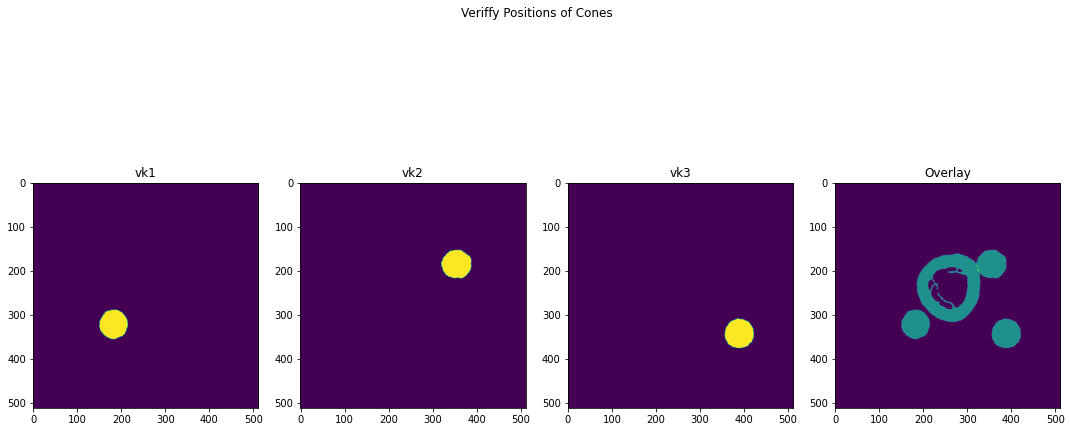

In [17]:
### Visualizes a section of the 3 cones to verify that these are actually segmented ###

# Compare to CT Positions
fig,ax = plt.subplots(1,4, figsize=(15,8))
fig.suptitle("Veriffy Positions of Cones")
fig.set_tight_layout(True)
angle =130
overlay = vk1[:,:,idx1]+vk2[:,:,idx2]+vk3[:,:,idx3]+vkbone[:,:,200]
I1 = rotate(vk1[:,:,idx1], angle=angle, reshape= False)
# I1 = np.flip(I1,0)
I1 = np.flip(I1,1)
I2 = rotate(vk2[:,:,idx2], angle=angle, reshape= False)
#I2 = np.flip(I2,0)
I2 = np.flip(I2,1)
I3 = rotate(vk3[:,:,idx3], angle=angle, reshape= False)
#I3 = np.flip(I3,0)
I3 = np.flip(I3,1)
overlay = rotate(overlay, angle=angle, reshape= False)
overlay =np.flip(overlay,1)
#overlay =np.flip(overlay,0)

ax[0].set_title("vk1")
ax[0].imshow(I1)
ax[1].set_title("vk2")
ax[1].imshow(I2)
ax[2].set_title("vk3")
ax[2].imshow(I3)
ax[3].set_title("Overlay")
ax[3].imshow(overlay)

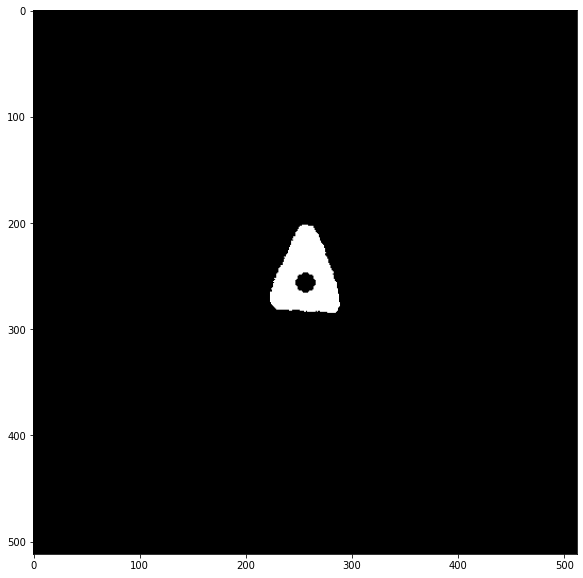

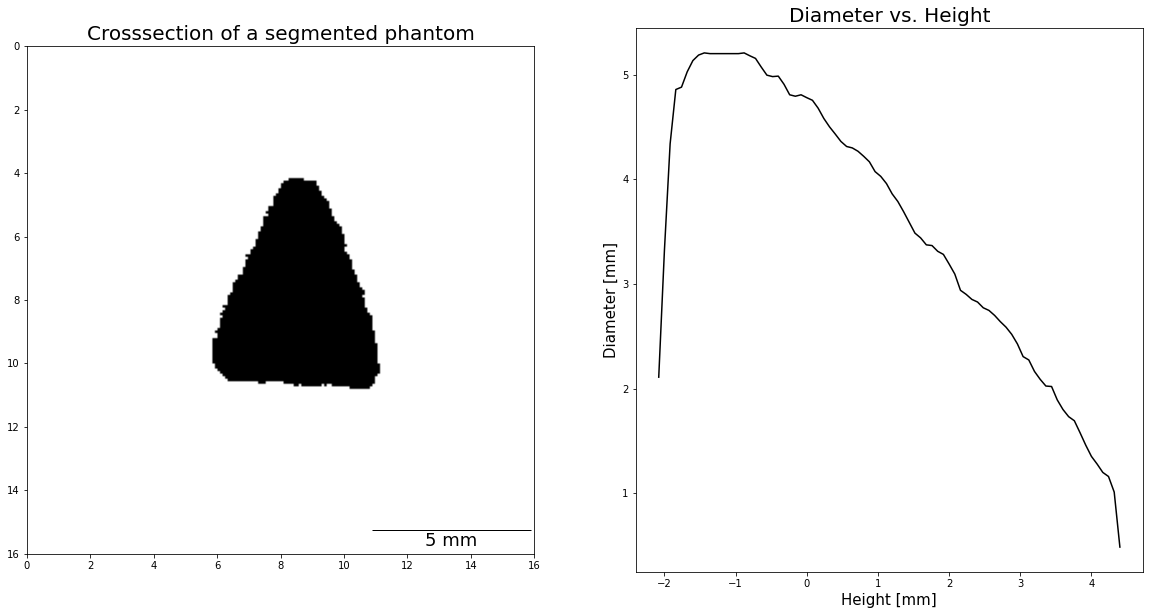

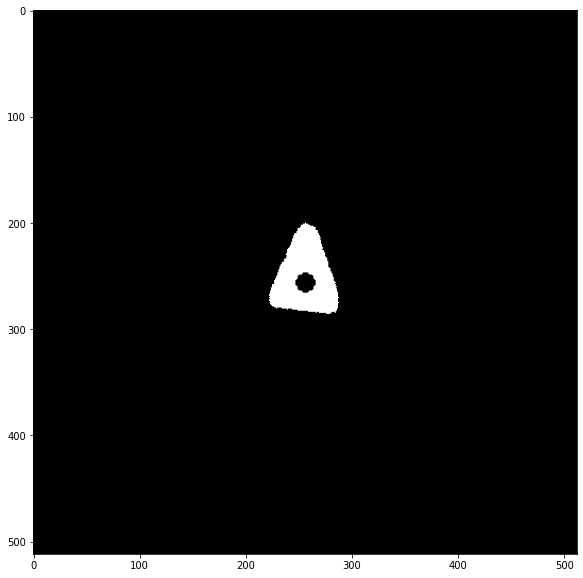

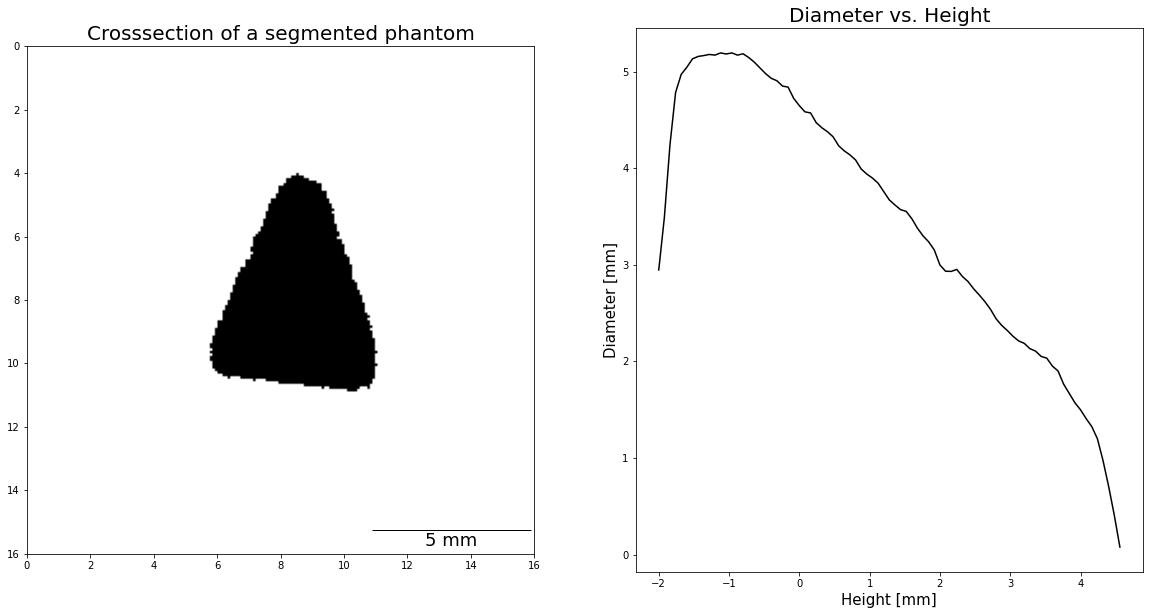

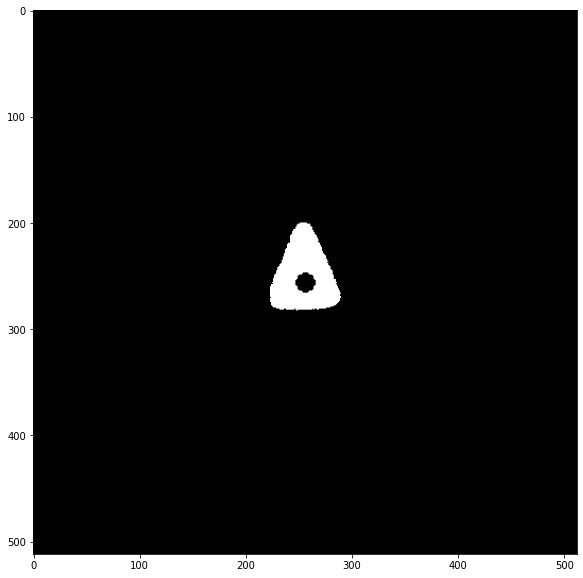

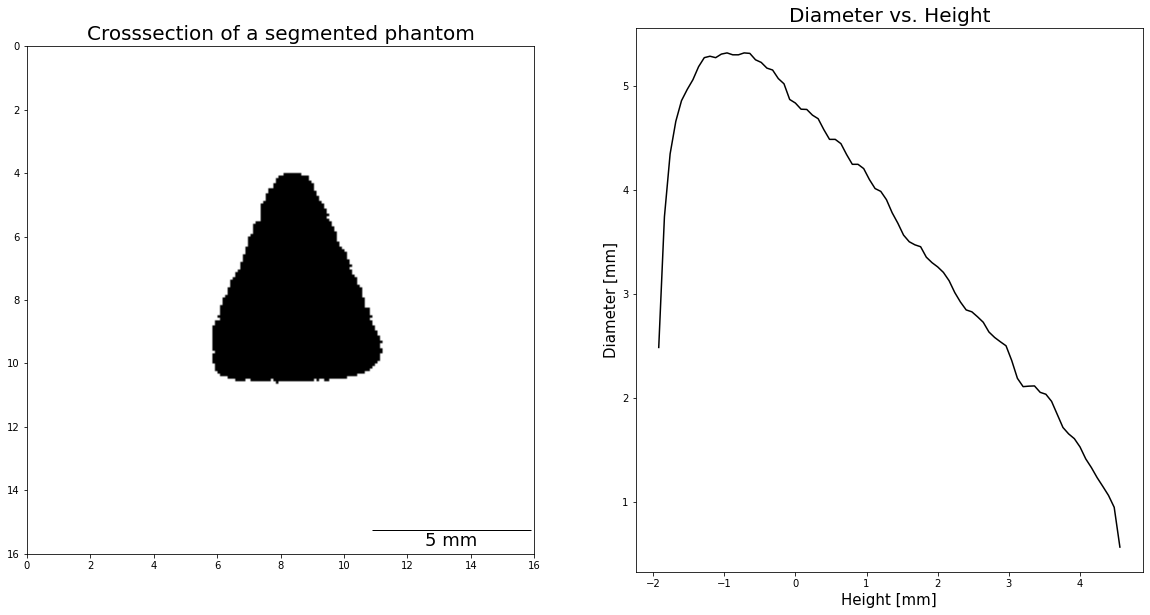

In [18]:
### Map each diameter of the cone to a given height. The height values are centered around the center of mass ###


fig1,diameter1,height1 = get_diameter(aivk1 , centroid1,vk1)
fig2,diameter2,height2 = get_diameter(aivk2, centroid2,vk2)
fig3,diameter3,height3 = get_diameter(aivk3 ,centroid3,vk3)

# scale according to ct resolution
diameter1 = diameter1*ct_scale
diameter2 = diameter2*ct_scale
diameter3 = diameter3*ct_scale

#Clean false data
diameter2[1] = 0

vk_diameter = np.array([diameter1,diameter2,diameter3])
#fig1.savefig('graph.png',dpi=600)


In [19]:
### Match the parameters found in the histo image with the right diameter from the CT-Scan ###

closest = []

radius_hist = []

# Four each found minor axis from the histological image
for i in range(len(df_params.loc[:,'minoraxis'])):
  
  # radius_hist.append((df_params.loc[:,'majoraxis'][i] +  df_params.loc[:,'minoraxis'][i])/2)
  radius_hist.append((df_params.loc[:,'minoraxis'][i]))

print(radius_hist)
## Find the diameter with the smallest difference ###
### HAVE TO BE MATCHED MANUALLY ###

closest.append([np.abs(vk_diameter[0] - radius_hist[0] ).argmin()])
closest.append([np.abs(vk_diameter[1]  - radius_hist[1] ).argmin()])
closest.append([np.abs(vk_diameter[2]  - radius_hist[2] ).argmin()])

print("The closests indicies on the axis of inertia ")
print(closest)

print(height1[closest[0][0]],radius_hist[0])
print(height2[closest[1][0]],radius_hist[1])
print(height3[closest[2][0]],radius_hist[2])


print("Matched diameter (CT, histology ):")
print(vk_diameter[0][closest[0][0]] ,radius_hist[0])
print(vk_diameter[1][closest[1][0]] ,radius_hist[1])
print(vk_diameter[2][closest[2][0]],radius_hist[2])


[4.039024621582032, 3.818550653076172, 3.6257174499511717]
The closests indicies on the axis of inertia 
[[39], [39], [42]]
13.0 4.039024621582032
14.0 3.818550653076172
18.0 3.6257174499511717
Matched diameter (CT, histology ):
4.0274285714285725 4.039024621582032
3.8468571428571443 3.818550653076172
3.680000000000001 3.6257174499511717


In [20]:
### get Coordinates of matched diameter and corresponding height ###

#Check the direction of the z-axis
if(aivk1[:,0][2]>0):
    search_point1 =  centroid1 + height1[closest[0][0]]*aivk1[:,0]
else:
    search_point1 =  centroid1 - height1[closest[0][0]]*aivk1[:,0]
search_point1= list(map(int, search_point1 ))
print(aivk1[:,0])
print(height1[closest[0][0]]*aivk1[:,0])
print( centroid1)
print(search_point1)

[-0.14339928 -0.10403514 -0.98418156]
[ -1.86419059  -1.35245685 -12.79436024]
[271.34385637 160.76404179 222.76129125]
[273, 162, 235]


In [21]:
if(aivk2[:,0][2]>0):
    search_point2 =  centroid2 + height2[closest[1][0]]*aivk2[:,0]
else:
    search_point2 =  centroid2 - height2[closest[1][0]]*aivk2[:,0] 
search_point2= list(map(int, search_point2 ))
print(aivk2[:,0])
print(height2[closest[1]]*aivk2[:,0])
print( centroid2)
print(search_point2)

[-0.18539132 -0.35741667 -0.9153597 ]
[ -2.59547854  -5.00383332 -12.81503583]
[227.39227863 377.26774437 162.68801051]
[229, 382, 175]


In [22]:
if(aivk3[:,0][2]>0):
    search_point3 =  centroid3 + height3[closest[2][0]]*aivk3[:,0]
else:
    search_point3 =  centroid3 - height3[closest[2][0]]*aivk3[:,0] 
search_point3= list(map(int, search_point3 )) 
print(aivk3[:,0])
print(height3[closest[2]]*aivk3[:,0])
print( centroid3)
print(search_point3)

[0.12639915 0.25840342 0.95773218]
[ 2.27518473  4.65126158 17.23917922]
[100.29017654 276.78999559 215.08727866]
[102, 281, 232]


In [23]:
## The next cells are mostly used for visualization ####

print(search_point1,search_point2,search_point3)
v666 = np.zeros_like(v1)
for i in range(10):
    for j in range(10):
        for k in range(10):
            v666[search_point1[0]+i,search_point1[1]+j,search_point1[2]+k] = 1
            v666[search_point2[0]+i,search_point2[1]+j,search_point2[2]+k] = 1
            v666[search_point3[0]+i,search_point3[1]+j,search_point3[2]+k] = 1

[273, 162, 235] [229, 382, 175] [102, 281, 232]


In [24]:
### Put the points into an np array so the other functions work ###

search_point11 = np.array([search_point1 [0],search_point1 [1],search_point1 [2]])
search_point21 = np.array([search_point2 [0],search_point2 [1],search_point2 [2]])
search_point31 = np.array([search_point3 [0],search_point3 [1],search_point3 [2]])

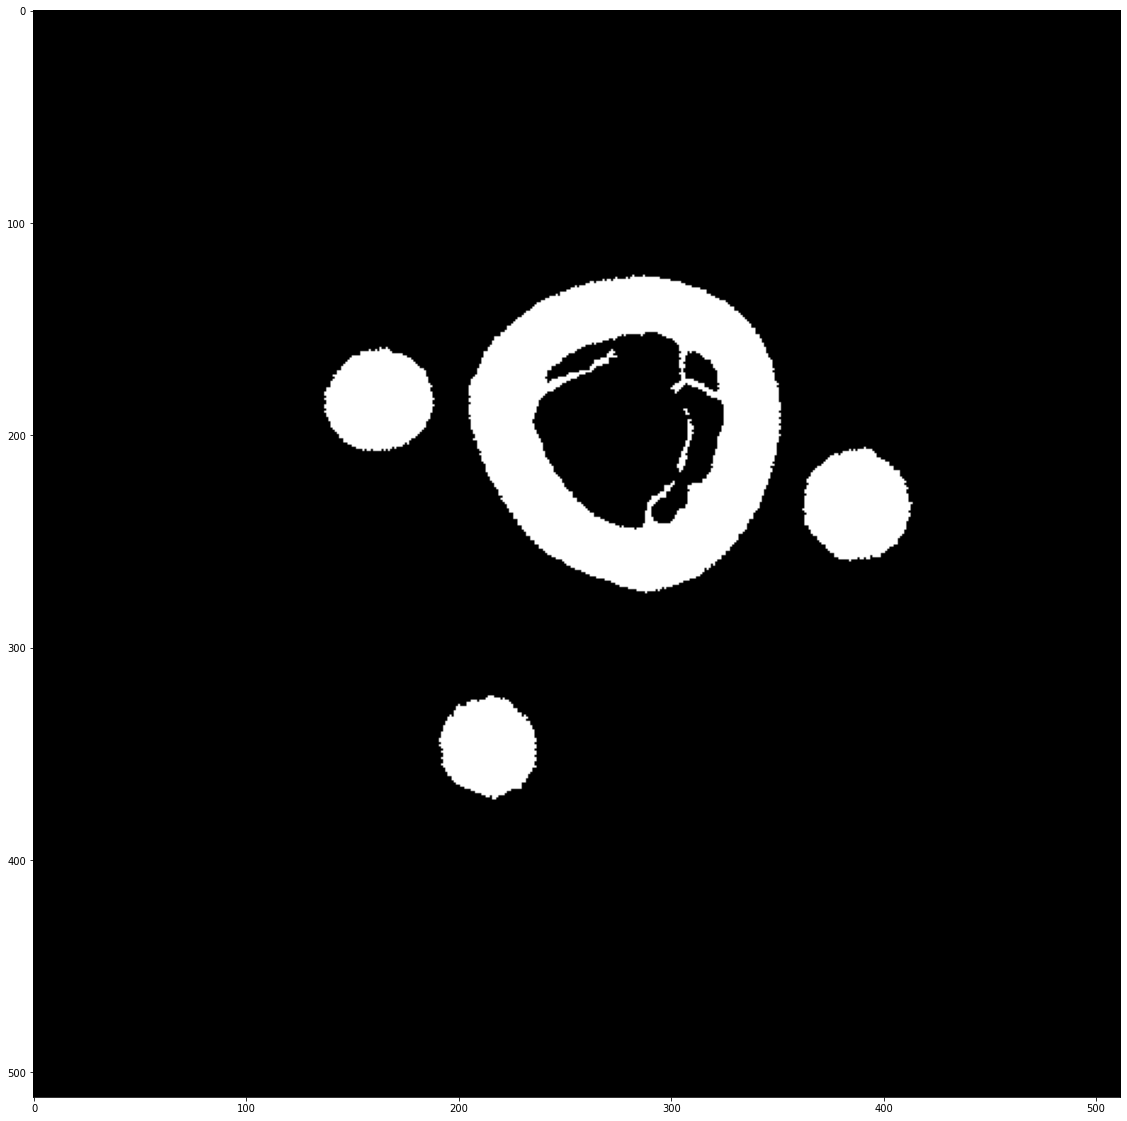

In [25]:
### Extract Plane from volume ###



# Create a matrx based on the matched point 
points = np.array([search_point11,search_point21,search_point31]).T
 #print(points)



# get center point 
center=np.mean(points, axis=1, keepdims=True)

# subtract out the centroid and take the SVD
svd = np.linalg.svd(points - center)
 #print(svd)
# Extract the left singular vectors
# (the most left vector is the one with the smallest eigenvalue and must therefore be the normal of the plane)
coordinate_system = svd[0]
 #print(coordinate_system)
 #print('z-axis ',coordinate_system[:,2])
 # we assume that the center point is now in the center of our plane
 
cp=[256,256,0]

def translation_candidate(diff,center):
    """
        Move Plane along normal to generate possible matching candidates
    """
    
    center_new = center.T +coordinate_system[:,2]*diff
    #print(center.T, center_new)
  

        # we create the inverse transformation of the plane coordinate system
    #T=np.linalg.inv(coordinate_system)
    T = coordinate_system
        # we generate an empty matrix
    I=np.zeros((512,512),dtype='float')
        

    # now we calculate the values for each pixel in the plane
    for x in range(0,512):
        for y in range(0,512):
                
                    # we move the pixel in centered coordinates and 
                    # project them back into 3D space using the inverse plane coordinate system,
            pos = T.dot([x-cp[0],y-cp[1],0])
                    
                    # we need to correct for the base point of the plane
            pos = (pos + center_new).flatten()

                    # now we need to interpolate the intensity or we just take the closest voxel for the moment
                    # we need to check if we projected outside the original data frame
            if pos[0]>0 and pos[0]<512 and pos[1]>0 and pos[1]<512 and pos[2]>0 and pos[2]<512 :
                  I[y,x]=v1[int(pos[0]),int(pos[1]),int(pos[2])]

    
#Flip and rotate if necesary


    I = np.flip(I,1)
    #I = np.rot90(I,1) 
 
    I[I>1]= 1
    I[I<0] = 0 

    return I, center_new


def rotation_candidate(angle, axis,center):
    """
        Rotate Plane around parameter axis and angle
    """
    theta= math.radians(angle)
    coordinate_system_new = np.copy(coordinate_system)
    rotm = np.empty((3,3))
    if (axis == 'x'):
    
        rotm = np.matrix([[ 1, 0           , 0           ],
                          [ 0, math.cos(theta),-math.sin(theta)],
                          [ 0, math.sin(theta), math.cos(theta)]])
        coordinate_system_new[:,0] = coordinate_system_new[:,0]*rotm

    elif (axis == 'y'):
        rotm =np.matrix([[ math.cos(theta), 0, math.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-math.sin(theta), 0, math.cos(theta)]])
        coordinate_system_new[:,1] = coordinate_system_new[:,1]*rotm
  
    else:
        rotm = np.empty((3,3))
   
    center_new = center

    # we create the inverse transformation of the plane coordinate system
    T=coordinate_system_new

        # we generate an empty matrix
    I=np.zeros((512,512),dtype='float')
        

    # now we calculate the values for each pixel in the plane
    for x in range(0,512):
        for y in range(0,512):
                
                    # we move the pixel in centered coordinates and 
                    # project them back into 3D space using the inverse plane coordinate system,
            pos = T.dot([x-cp[0],y-cp[1],0])
                    
                    # we need to correct for the base point of the plane
            pos = (pos + center_new.T).flatten()

                    # now we need to interpolate the intensity or we just take the closest voxel for the moment
                    # we need to check if we projected outside the original data frame
            if pos[0]>0 and pos[0]<512 and pos[1]>0 and pos[1]<512 and pos[2]>0 and pos[2]<512 :
                I[y,x]=v1[int(pos[0]),int(pos[1]),int(pos[2])]
    #I = np.rot90(I,2)  
    I = np.flip(I,0) 
    I[I>1]= 1
    I[I<0] = 0 
    return I,  center_new; 

Inormal,  center_normal  = translation_candidate(0,center)
f, ax = plt.subplots(1,1, figsize = (20,20))
ax.imshow(Inormal, cmap = "gray")

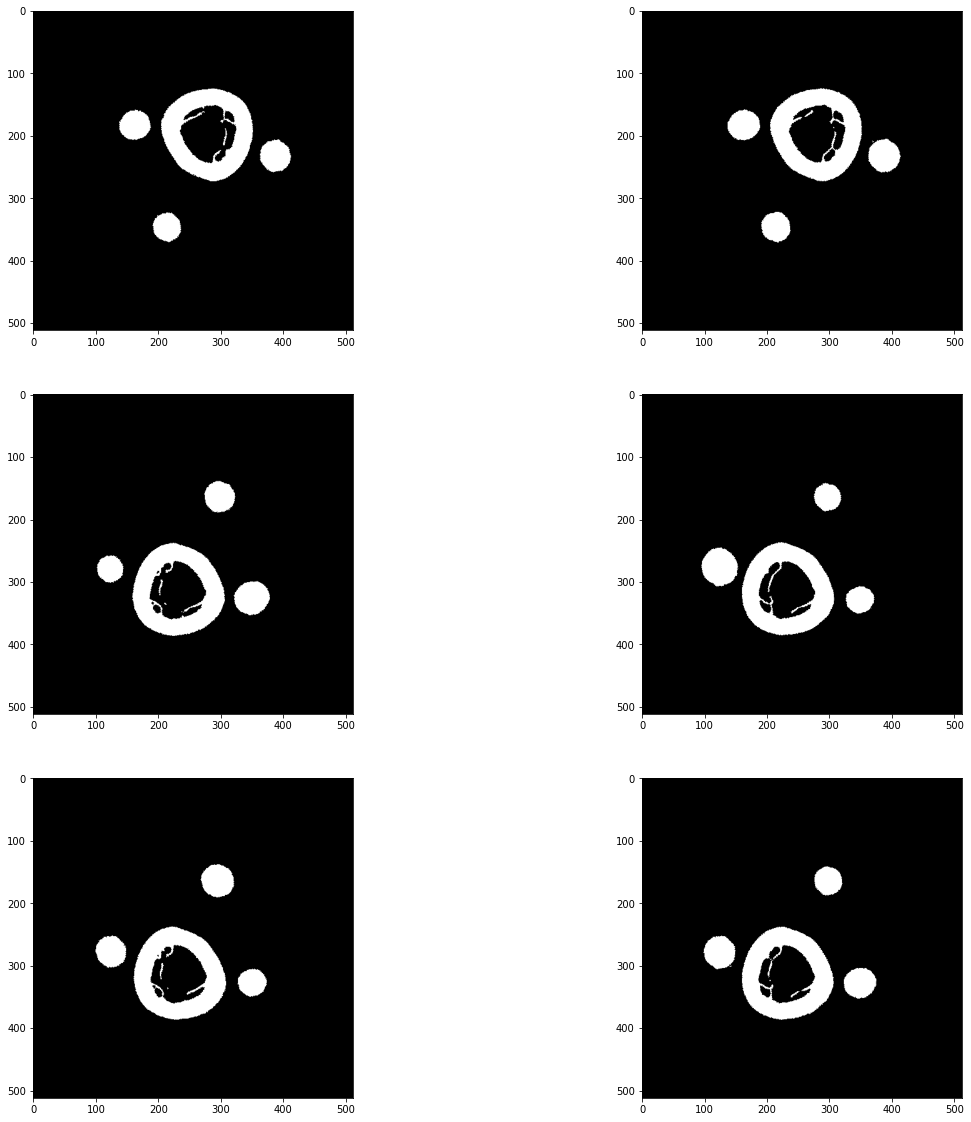

In [26]:
### Generate slightly transformed matching candidates ###

Itrans5, center_trans5 = translation_candidate(1,center)
Itransn5, center_transn5  = translation_candidate(-1,center)
Irotx3, center_rotx3  =  rotation_candidate(5, 'x',center)
Irotxn3, center_rotxn3  =  rotation_candidate(-5, 'x',center)
Iroty3, center_roty3 =  rotation_candidate(5, 'y',center)
Irotyn3, center_rotyn3  =  rotation_candidate(-1, 'y',center)

fig, ax = plt.subplots(3, 2, figsize=(20, 20))
ax[0,0].imshow(Itrans5,cmap = "gray")
ax[0,1].imshow(Itransn5,cmap = "gray")
ax[1,0].imshow(Irotx3,cmap = "gray")
ax[1,1].imshow(Irotxn3,cmap = "gray")
ax[2,0].imshow(Iroty3,cmap = "gray")
ax[2,1].imshow(Irotyn3,cmap = "gray")

plt.show()

In [27]:
### Function to plot the current status of the registration ###
### The following code snippits were obtained from the following link and edited ###
### https://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/60_Registration_Introduction.html ###

%matplotlib inline

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

Scale facor: 13.559322033898306


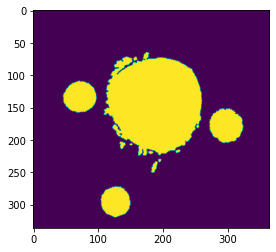

In [28]:
### Scale, rotatate roughly and change type of histology mask ###

hist_rot = 20
#print(Itransn5.dtype)
#print(Itransn5.astype(int).dtype)
r3 = cv2.imread('mask.png', cv2.IMREAD_GRAYSCALE)
print("Scale facor: "+str(ct_scale/hist_scale))
widht = int(r3.shape[0]/(ct_scale/ hist_scale))
height = int(r3.shape[1]/(ct_scale/ hist_scale))
#print(widht, height)
resized = cv2.resize(r3,(height,widht))

#print(resized.astype(int).dtype)
#print(resized.shape)
resized = rotate(resized,angle=hist_rot)
plt.imshow(resized.astype(int))

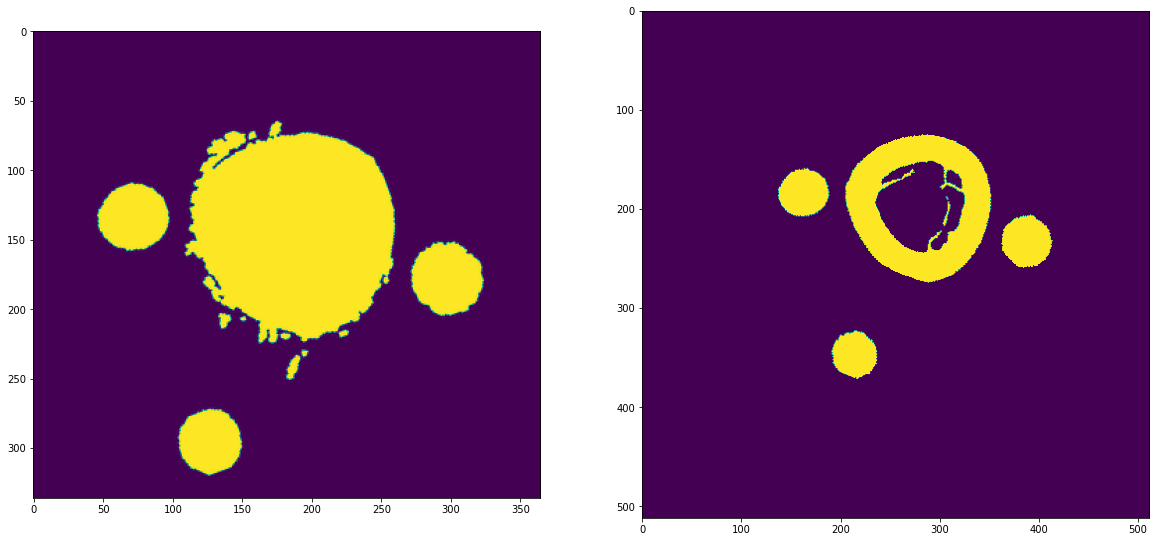

In [29]:
### set Input Images ###

moving_image = sitk.GetImageFromArray(resized.astype(int))
fixed_image = sitk.GetImageFromArray(Inormal.astype(int))
npa_zslice1 = sitk.GetArrayViewFromImage(moving_image)
npa_zslice2 = sitk.GetArrayViewFromImage(fixed_image)



f, ax = plt.subplots(1,2, figsize = (20,20))
ax[0].imshow(npa_zslice1)
ax[1].imshow(npa_zslice2)

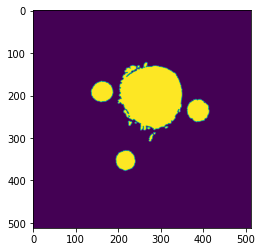

In [30]:
### Set inital transformation parameters ###
### The following code snippits were obtained from the following link and edited ###
### https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1AffineTransform.html#a35bd79dc81f6d81ae8a22d8664b36898 ###


initialTransform = sitk.Euler2DTransform()
#initialTransform.Scale(round(ct_scale/hist_scale))
#initialTransform.Scale(13)
initial_transform = initialTransform
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      initialTransform, sitk.CenteredTransformInitializerFilter.MOMENTS
                                                      )

# Creat stik image for initial transforma
moving_resampled = sitk.Resample(moving_image, fixed_image,initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())



npa_zslice = sitk.GetArrayViewFromImage(moving_resampled)
plt.imshow(npa_zslice)



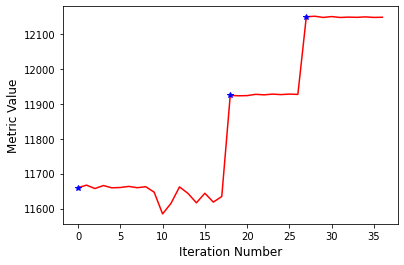

In [31]:
### Perform Registration ###
### The following code snippits were obtained from the following link and edited ###
### https://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/60_Registration_Introduction.html ###

registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMeanSquares()
#This value has been changed on my private my machine
registration_method.SetMetricSamplingPercentage(1)
registration_method.SetOptimizerScales
registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=0.001,numberOfIterations=1500 )



# Setup for the multi-resolution framework.            
registration_method.SetOptimizerScalesFromPhysicalShift() 
registration_method.SetInitialTransform(initial_transform, inPlace=True)
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
# Don't optimize in-place, we wo0d possibly like to run this cell multiple times.

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image,sitk.sitkFloat32), sitk.Cast(moving_image,sitk.sitkFloat32))


In [32]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: 12151.376812349514
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 10.


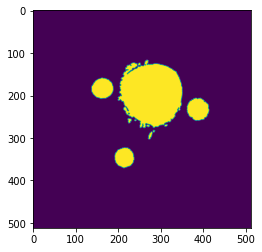

In [33]:
### Resample transformed image ###

moving_resampled1 = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
npa_zslice = sitk.GetArrayViewFromImage(moving_resampled1)
plt.imshow(npa_zslice)



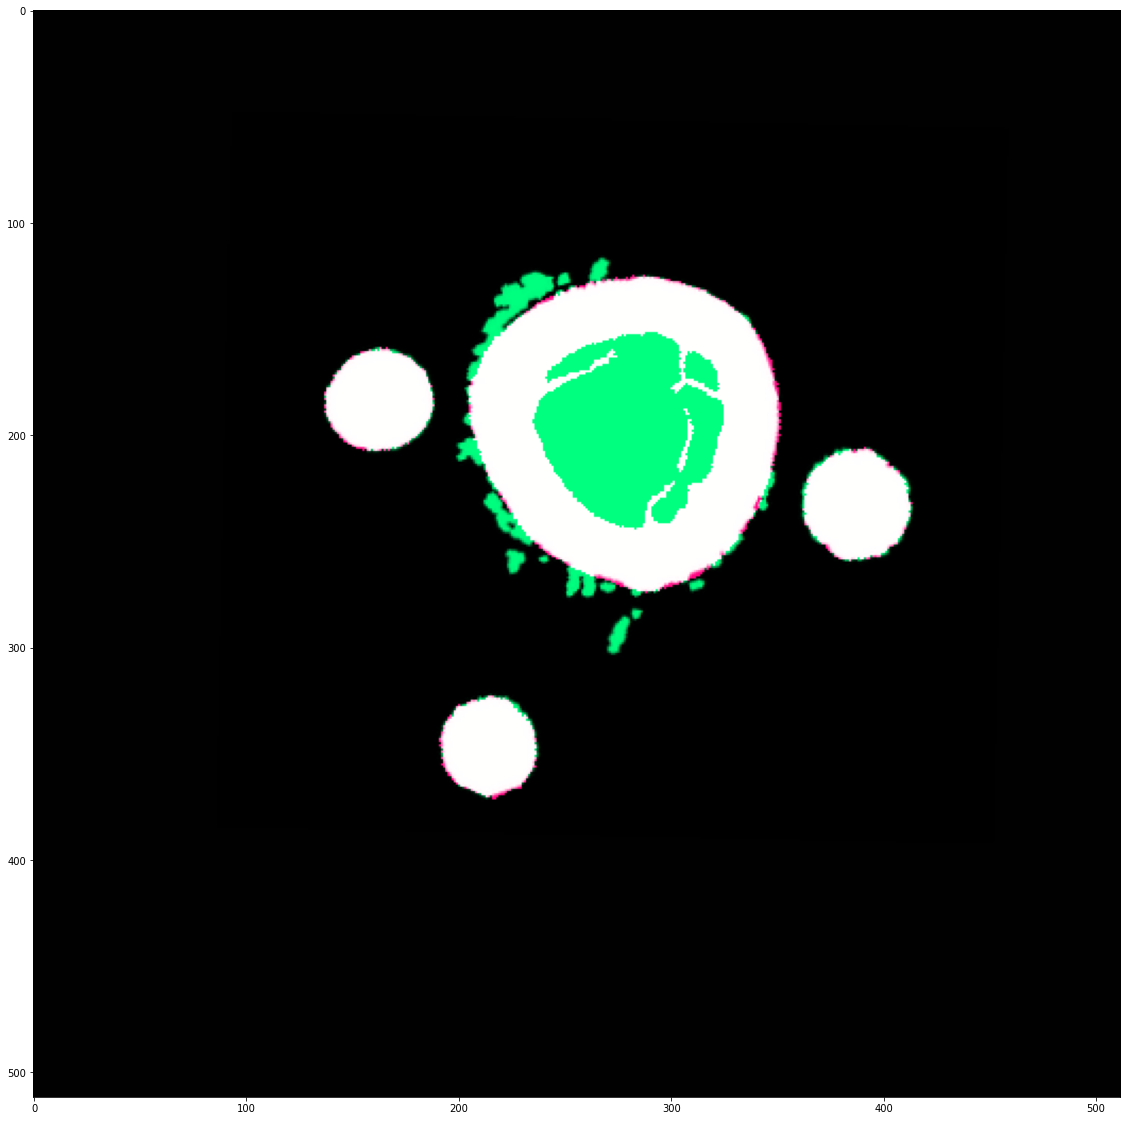

In [34]:
### Overlay the resampled and ground truth image ###

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed_image)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(1)
resampler.SetTransform(final_transform)
out = resampler.Execute(moving_image)
simg1 = sitk.Cast(sitk.RescaleIntensity(fixed_image), \
                  sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
cimg = sitk.Compose(simg1, simg2, simg1//2.+simg2//2.)

npa_zslice1 = sitk.GetArrayViewFromImage(simg1)
npa_zslice2 = sitk.GetArrayViewFromImage(simg2)
npa_zslice3 = sitk.GetArrayViewFromImage(cimg)

f, ax = plt.subplots(1,1, figsize = (20,20))

ax.imshow(npa_zslice3)

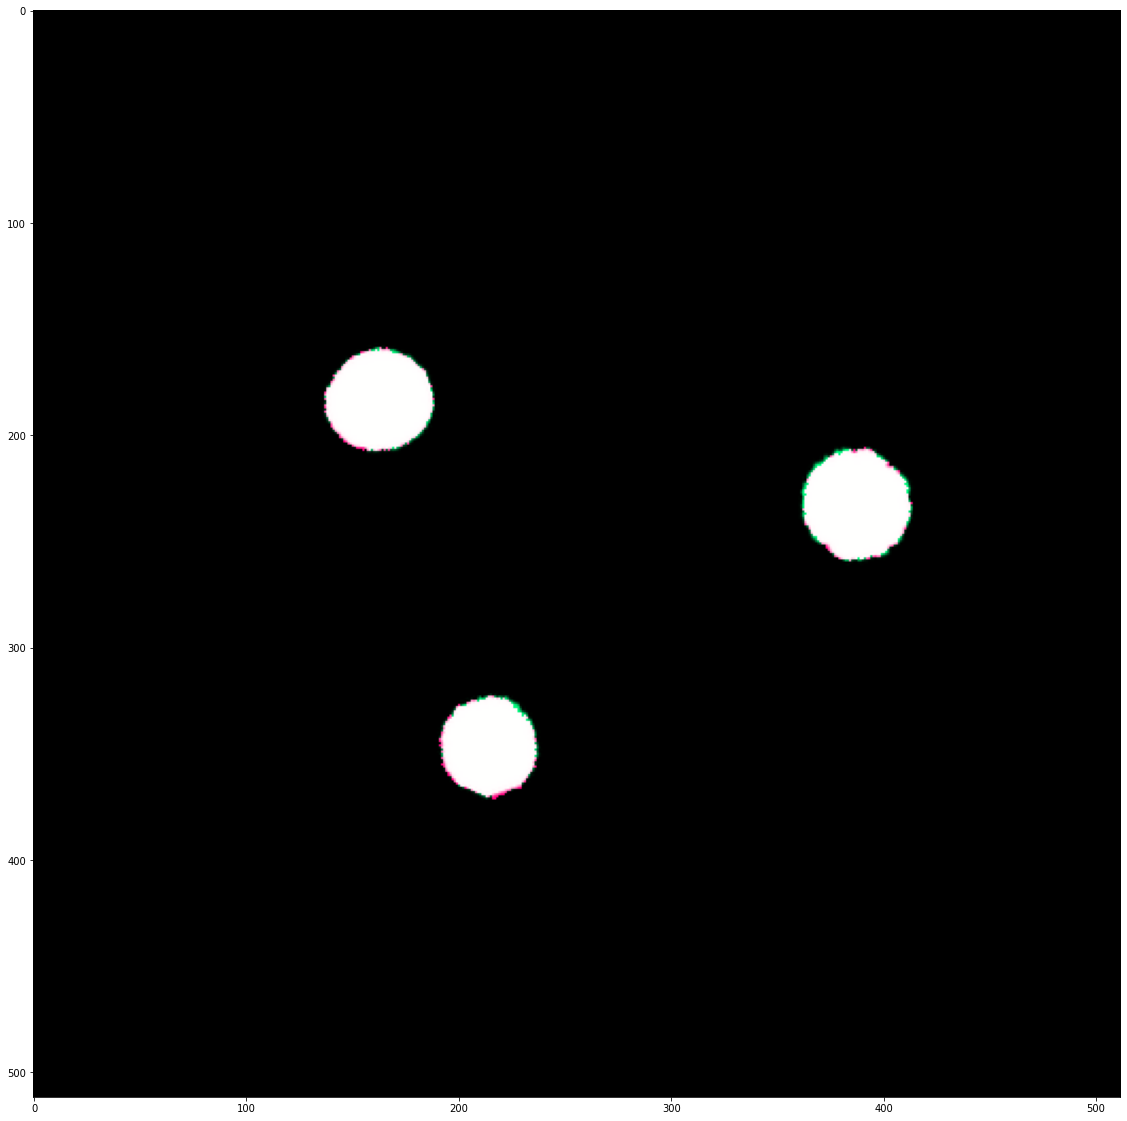

In [35]:
### Delete the histo plane. Remove the bone and small artefacts ###

copy = np.copy(npa_zslice3)
  
plt.figure(figsize=(20,20))
copy[:,:,1][copy[:,:,1] == 1] = 0


label_c1,cnumfeaturesplane = label(copy[:,:,1])
for region in regionprops(label_c1):
    if region.area <500 or region.area > 8000:
        min_row, min_col, max_row, max_col =  region.bbox
        copy[min_row:max_row, min_col:max_col,0] = 0
        copy[min_row:max_row, min_col:max_col,1] = 0
        copy[min_row:max_row, min_col:max_col,2] = 0

label_c,cnumfeaturesplane = label(copy[:,:,1])
for region in regionprops(label_c):
    # take regions with large enough areas
    if region.extent < 0.6 : #extent is the ratio between the filled and empty spaces in a bbox
        min_row, min_col, max_row, max_col =  region.bbox
        copy[min_row:max_row, min_col:max_col,0] = 0
        copy[min_row:max_row, min_col:max_col,1] = 0
        copy[min_row:max_row, min_col:max_col,2] = 0

label_c2,cnumfeaturesplane = label(copy[:,:,0])
for region in regionprops(label_c2):
    if region.area <800 or region.area > 7500 or region.extent < 0.6  :
        min_row, min_col, max_row, max_col =  region.bbox
        copy[min_row:max_row, min_col:max_col,0] = 0
        copy[min_row:max_row, min_col:max_col,1] = 0
        copy[min_row:max_row, min_col:max_col,2] = 0



plt.imshow(copy)
#plt.imsave("Iou_comparision.png",copy)



False Positives: 38
False Negatives: 75
True Positives: 5593
IoU Score: 0.9802


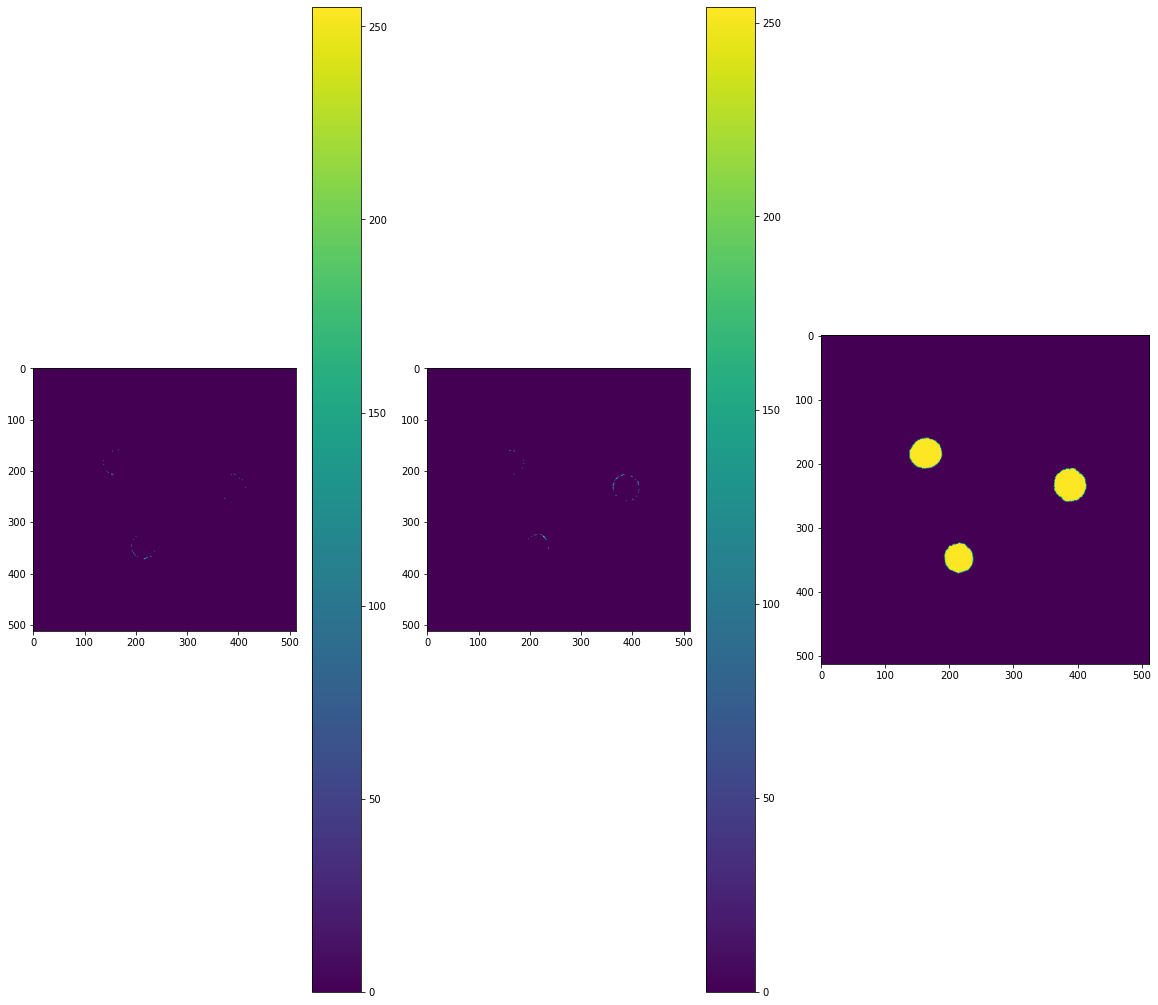

In [36]:
### Compute boolean values and calculate IoU ###

overlap = np.copy(copy)
overlap1 = cv2.bitwise_and(overlap[:,:,1],overlap[:,:,0])
I_diff1 = copy[:,:,0]-overlap1
I_diff2 = copy[:,:,1]-overlap1

# delete noise
I_diff1[I_diff1<200] = 0
I_diff2[I_diff2<200] = 0

#calculate pixels for each group
num_x = np.where(I_diff1  > 0)
num_y =np.where(I_diff2  > 0)
num_overlap =np.where(overlap1  > 0)
print("False Positives: "+str(len(num_x[1])))
print("False Negatives: "+str(len(num_y[1])))
print("True Positives: "+str(len(num_overlap[1])))

#Calculate IoU
iou =len( num_overlap[1])/(len(num_x[1])+len(num_y[1])+len(num_overlap[1]) )

print("IoU Score: "+str(round(iou,4)))

# Plot differences (XOR)
f, ax = plt.subplots(1,3, figsize = (20,20))
im = ax[0].imshow(I_diff1)
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(I_diff2)
plt.colorbar(im, ax=ax[1])
im = ax[2].imshow(overlap1)



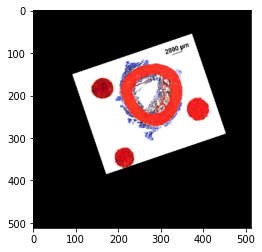

In [37]:
### Create an RGB transformed image ###

output_size = [512,512]
# Get Scaling and resize 

resized = cv2.resize(im_input,(height,widht))
resized = rotate(resized,angle = hist_rot)

#Resample image with transformation on each channel
org_image = sitk.GetImageFromArray(resized[:,:,0])
resampled = sitk.Resample(org_image,output_size, final_transform)
npa_zslice = sitk.GetArrayViewFromImage(resampled )
npa_slicer = np.copy(npa_zslice)

org_imageg = sitk.GetImageFromArray(resized[:,:,1])
resampled = sitk.Resample(org_imageg,output_size, final_transform)
npa_zsliceg = sitk.GetArrayViewFromImage(resampled )
npa_sliceg = np.copy(npa_zsliceg)

org_imageb = sitk.GetImageFromArray(resized[:,:,2])
resampled = sitk.Resample(org_imageb,output_size, final_transform)
npa_zsliceb = sitk.GetArrayViewFromImage(resampled )
npa_sliceb = np.copy(npa_zsliceb)

#Create imges for each array in unint8
imr=Image.fromarray(np.uint8(npa_slicer) , 'L') 
imb=Image.fromarray(np.uint8(npa_sliceb) , 'L')
img=Image.fromarray(np.uint8(npa_sliceg) , 'L')

# merge
merged=Image.merge("RGB",(imr,img,imb))

plt.imshow(merged)


[]

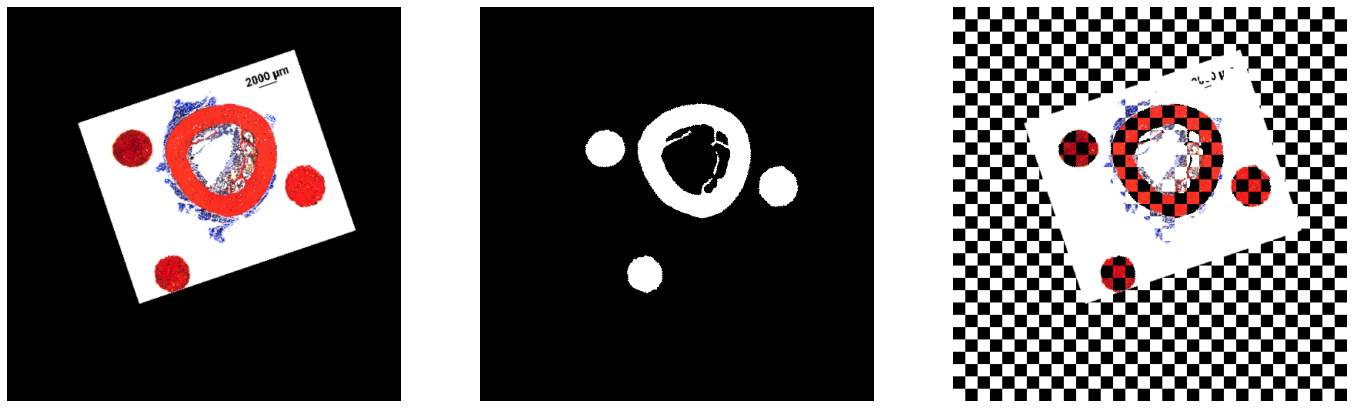

In [38]:
### Create a checker Board image of the ct scan and the histo image ###

def checkerboard(img1,img2,n_tiles=(32,32)):
    comp_img = compare_images(img1, img2, method='checkerboard',n_tiles=n_tiles)
    return comp_img

A =  np.asarray(merged)
# Invert image so the background is white 
B = 1-Inormal
C0=checkerboard(A[:,:,0],B[:,:])
C1=checkerboard(A[:,:,1],B[:,:])
C2=checkerboard(A[:,:,2],B[:,:])
C =np.stack([C0,C1,C2],axis=2)
fig = plt.figure(figsize=(24, 14))
ax=plt.subplot(131)
ax.imshow(A)
ax.axis('off')
ax=plt.subplot(132)
ax.imshow(B, cmap="Greys")
ax.axis('off')
ax=plt.subplot(133)
ax.imshow(C)
ax.axis('off')



plt.plot()

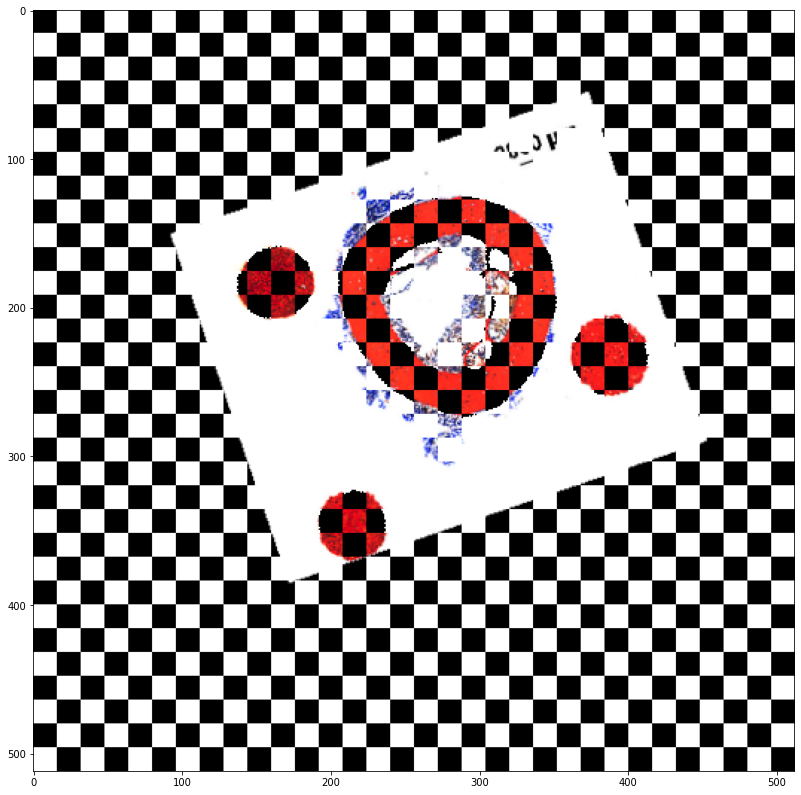

In [39]:
fig = plt.figure(figsize=(24, 14))
plt.imshow(C)
#imsave('checkerboard.png',C) 